In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os 
import time 
import glob as glob 
import numpy as np  # for math operation 
import pandas as pd  # for handling data and data frame 
import cv2  # OpenCV library, which will use to read images and transform them 
import matplotlib.pyplot as plt # to visualize data 
from tqdm import tqdm_notebook , trange # to see the progress of the codes 
import gc #garbage collection to save ram


%matplotlib inline 

from sklearn.model_selection import train_test_split

# pytorch libraries 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset,DataLoader, Dataset

### Step-1 Understanding and Visualizing the data 

In [3]:
# set path of traning and test data 

path = "../input/"
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')


In [4]:
df = pd.DataFrame({'path': glob.glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: os.path.splitext(os.path.basename(x))[0])
df = df.merge(labels,on='id')
train,val = train_test_split(labels,stratify=labels.label ,test_size=0.1)

df.head()

,path,id,label
0,/kaggle/input/histopathologic-cancer-detection...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,/kaggle/input/histopathologic-cancer-detection...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,/kaggle/input/histopathologic-cancer-detection...,b0d2582c6218a8764323fc940b41312282b99bf4,0
3,/kaggle/input/histopathologic-cancer-detection...,187c99df762f13f99818e5593d4bab4c6577e7e3,1
4,/kaggle/input/histopathologic-cancer-detection...,7c5270c83837de5a5cbb2dca511559dc39d19d53,1


In [5]:
train.count()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198022 entries, 143338 to 176922
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      198022 non-null  object
 1   label   198022 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.5+ MB


In [8]:
val.count()
val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22003 entries, 42934 to 111162
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22003 non-null  object
 1   label   22003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 515.7+ KB


In [9]:
def load_data(N,df):
    "this function load N images using the data frame df"

    # allocate the numpy array for the image (N , 96x96px, 3 channels(R,G,B), value 0-255)
    X = np.zeros([N,96,96,3],dtype = np.uint8)
    # convert the labels to a numpy array too
    y = df['label'].values[:N]
    # read images one by one 
    for i, row in tqdm_notebook(df.iterrows(),total=N):
        if i==N :
            break
        X[i] = cv2.imread(row["path"])

    return X,y

In [10]:
N = 25000
X,y  = load_data(N,df)

/tmp/ipykernel_142/3109664171.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(),total=N):


  0%|          | 0/25000 [00:00<?, ?it/s]

### Let's see what our data look like!


/tmp/ipykernel_142/223943439.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


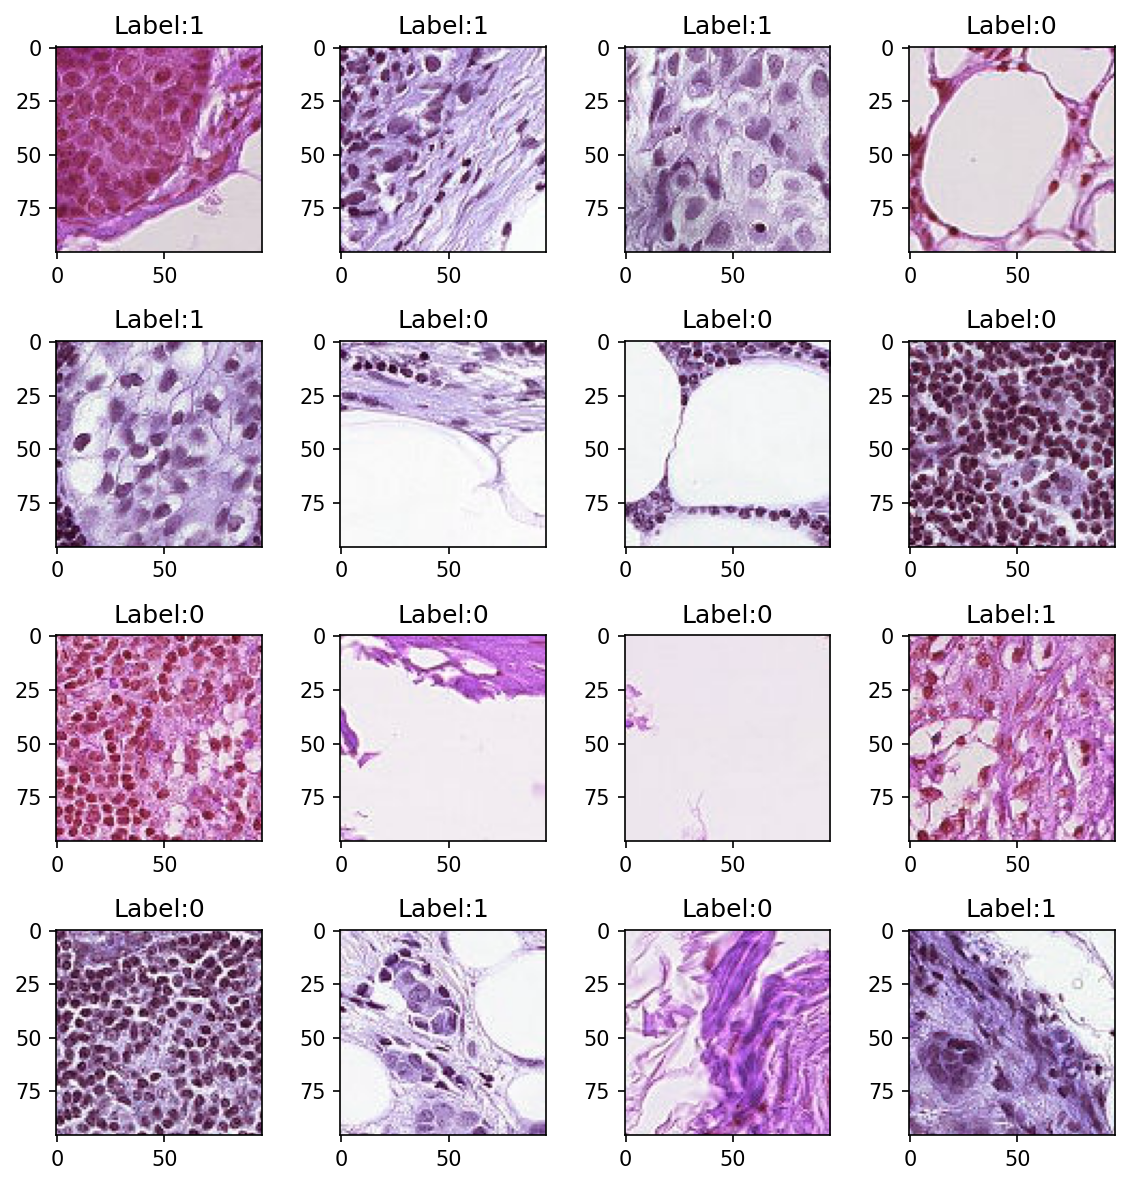

In [11]:
fig = plt.figure(figsize =(8,8),dpi=150)
np.random.seed(100) # we can use this seed to get a diffrent set of random images 
image_count =  16 # number of images we want to have

# iterate over a list of random numbers, then plot images with lables 
for plot_idx , image_idx in enumerate(np.random.randint(0,N,image_count)):
    ax  = fig.add_subplot(4,4,plot_idx+1)
    plt.imshow(X[image_idx])
    ax.set_title('Label:'+ str(y[image_idx]))
    plt.tight_layout()

### Let's analyze the positive and negative sample distribution in our data to see if it has any bias


Text(0, 0.5, 'No.of samples')

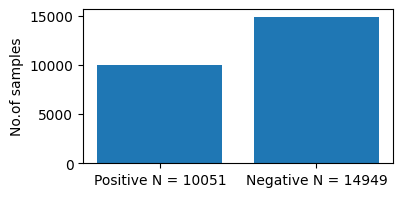

In [12]:
fig = plt.figure(figsize=(4,2),dpi = 100)
# plot bars of numbers of +ve and -ve samples 

number_of_negatives = (y==0).sum()
number_of_positives= (y==1).sum()
negative_samples = X[y==0]
positive_samples = X[y==1]
plt.bar([1,0],[number_of_negatives,number_of_positives])
plt.xticks([1,0],["Negative N = "+ str(number_of_negatives),
                 "Positive N = "+ str(number_of_positives)])

plt.ylabel("No.of samples")

In [ ]:
X

In [ ]:
positive_samples

#### Now we wonder if it is possible to diffrentiate bw the positive and negative sample just from the image . To check this , we will look at whether negative samples gernally have diffrent colour or brightness compare to the positive samples.

1. first compare each channel (red,green,blue) of positives and negatives.
2. then make a cumulative comparision
3. Finally, compare overall brightness
4. Scroll back up and compare your conclusion with the 16 images you have. is it accurate? 

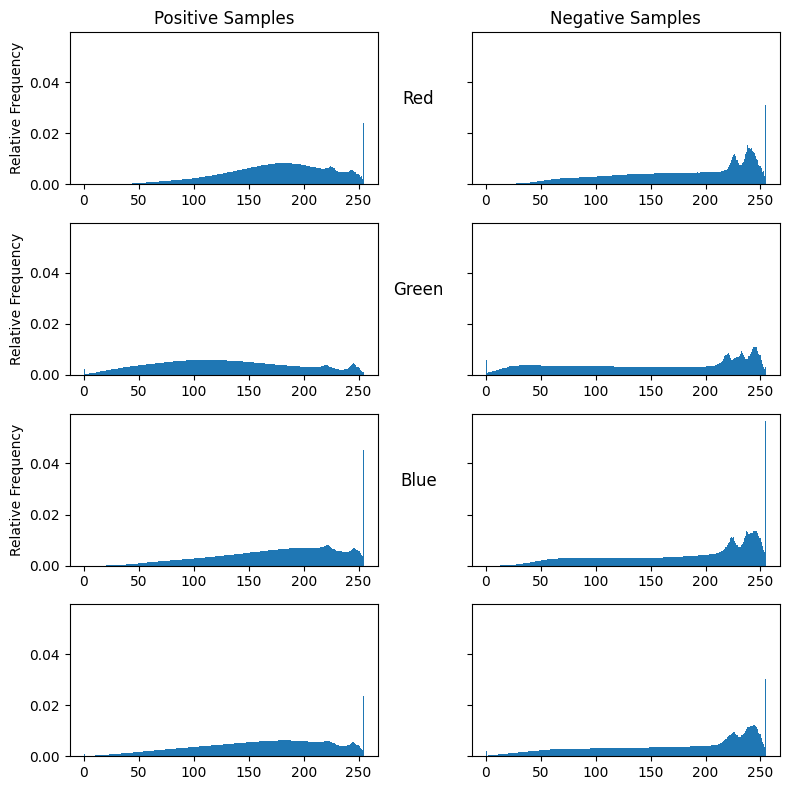

In [13]:
nr_of_bins = 256  # each possible pixel value get a bin in the following histogram 
fig,axs = plt.subplots(4,2,sharey = True , figsize=(8,8),dpi=100) 
rgb_list = ["Red","Green","Blue","RGB"]

# append a histogram at each of the to each of the positions of axis 
for row_idx in range(4):
    for col_idx in range(2):
        if row_idx < 3:
            axs[row_idx,0].set_ylabel("Relative Frequency")
            axs[row_idx,1].set_ylabel(rgb_list[row_idx],rotation = 'horizontal',
                                     labelpad=35,fontsize =12)

            # show the colour channel 
            if col_idx == 0 : #show +ve samples
                axs[row_idx,0].hist(positive_samples[:,:,:,row_idx].flatten(),
                                   bins = nr_of_bins , density = True)

            elif col_idx == 1 : #show -ve samples
                axs[row_idx,1].hist(negative_samples[:,:,:,row_idx].flatten(),
                                   bins = nr_of_bins , density = True)
            
        else :
            # here we have to show the rgb as cumulative 
            if col_idx == 0: # how +ve samples
                axs[row_idx,0].hist(positive_samples.flatten(),
                                   bins = nr_of_bins , density = True)
            elif col_idx == 1 : #show -ve samples
                axs[row_idx,1].hist(negative_samples.flatten(),
                                   bins = nr_of_bins , density = True)

axs[0,0].set_title("Positive Samples")
axs[0,1].set_title("Negative Samples")
plt.tight_layout()


### Step 2 : Preprocessing the data 

Now that we have our data, we want to turn it into something that our CNN model can take as an input. In order to improve the accuracy of our model in the real world, we will introduce something called transformations. Transformations allow us to play with our data so that they are imperfect and unpredictable, which intuitively sounds weird, but it actually helps our model to be have a greater test accuracy because it prevents overfitting. Transformations also allow us to have more variety, which again improves the real world application of it

In [ ]:
# # transform training data 

# trans_train = transforms.Compose([
#                                     transforms.ToPILImage(),
#                                     transforms.Pad(64,padding_mode = "reflect"),
#                                     transforms.RandomHorizontalFlip(),
#                                     transforms.RandomVerticalFlip(),
#                                     transforms.ToTensor(), # (h,w,c)--> (c,h,w)
#                                     transforms.Normalize(mean=[0.5,0.5,0.5],std = [0.5,0.5,0.5])

# ])


# # transform validation data 

# trans_val = transforms.Compose([
#                                     transforms.ToPILImage(),
#                                     transforms.Pad(64,padding_mode = "reflect"),
#                                     transforms.ToTensor(), # (h,w,c)--> (c,h,w)
#                                     transforms.Normalize(mean=[0.5,0.5,0.5],std = [0.5,0.5,0.5])

# ])


In [14]:
trans_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

trans_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [15]:
class MyDataset(Dataset):
    def __init__(self,df_data,data_dir = "./",transform = None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        image_name , label = self.df[index]
        image_path = os.path.join(self.data_dir , image_name + '.tif')
        image = cv2.imread(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image,label

In [16]:
# get train and validation data 
data_train = MyDataset(train,train_path,trans_train)
data_val = MyDataset(val,train_path,trans_val)

# loading the train and validation data 
#loader_train  = DataLoader(dataset = data_train , batch_size  = batch_size , shuffel = True , num_workers = 0)
#loader_val  = DataLoader(dataset = data_val, batch_size  = batch_size//2 , shuffel = False , num_workers = 0)


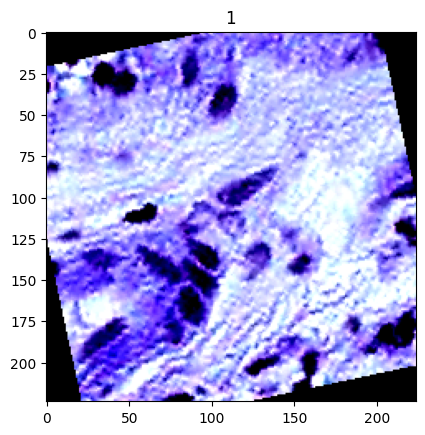

In [17]:
# plot a transformed image to see how diffrent it is 
import random 
random.seed(10)
random_idx = random.randint(0, len(data_train) - 1)
image , label = data_train[random_idx]
plt.imshow(image.permute(1,2,0)) # (c,h,w)-->(h,w,c)
plt.title(label)
plt.show()

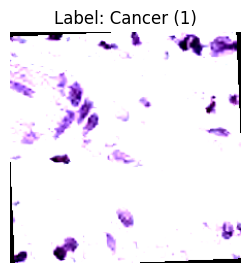

In [18]:
import random
import matplotlib.pyplot as plt

random.seed(10)
random_idx = random.randint(0, len(data_train) - 1)
image, label = data_train[random_idx]

# Reverse normalization for visualization
img_show = image * 0.5 + 0.5  
label_text = "Cancer" if label == 1 else "Normal"

plt.figure(figsize=(3, 3))
plt.imshow(img_show.permute(1, 2, 0))
plt.title(f"Label: {label_text} ({label})")
plt.axis("off")
plt.show()


## using EfficientNet

In [19]:
!pip install -U efficientnet-pytorch


In [20]:
from efficientnet_pytorch import EfficientNet

# Load pretrained EfficientNet-B0
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace the final classifier with your number of classes (2)
num_features = model._fc.in_features
model._fc = nn.Linear(num_features, 2)


Loaded pretrained weights for efficientnet-b0


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [22]:
batch_size = 32

loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=2)
loader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False, num_workers=2)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)



In [24]:
num_epochs = 10  # start with 10, increase if needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in loader_val:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    scheduler.step(val_acc)  # update LR if needed

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/10] | Train Loss: 0.2254 | Train Acc: 0.9116 | Val Loss: 0.1401 | Val Acc: 0.9558
Epoch [2/10] | Train Loss: 0.1576 | Train Acc: 0.9420 | Val Loss: 0.1038 | Val Acc: 0.9659
Epoch [3/10] | Train Loss: 0.1354 | Train Acc: 0.9510 | Val Loss: 0.0958 | Val Acc: 0.9695
Epoch [4/10] | Train Loss: 0.1202 | Train Acc: 0.9572 | Val Loss: 0.0836 | Val Acc: 0.9723
Epoch [5/10] | Train Loss: 0.1123 | Train Acc: 0.9602 | Val Loss: 0.0797 | Val Acc: 0.9735
Epoch [6/10] | Train Loss: 0.1025 | Train Acc: 0.9638 | Val Loss: 0.0955 | Val Acc: 0.9681
Epoch [7/10] | Train Loss: 0.0955 | Train Acc: 0.9665 | Val Loss: 0.0738 | Val Acc: 0.9763
Epoch [8/10] | Train Loss: 0.0899 | Train Acc: 0.9684 | Val Loss: 0.0770 | Val Acc: 0.9749
Epoch [9/10] | Train Loss: 0.0849 | Train Acc: 0.9704 | Val Loss: 0.0800 | Val Acc: 0.9753
Epoch [10/10] | Train Loss: 0.0803 | Train Acc: 0.9717 | Val Loss: 0.0731 | Val Acc: 0.9783


In [25]:
class TestDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = os.path.join(self.data_dir, img_id + '.tif')
        image = cv2.imread(img_path)
        if self.transform:
            image = self.transform(image)
        return image, img_id

test_dataset = TestDataset(submission, test_path, trans_val)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

model.eval()
predictions = []
with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:,1]  # probability of class 1
        predictions.extend(zip(ids, probs.cpu().numpy()))

# Save submission
submission['label'] = [p[1] for p in predictions]
submission.to_csv("submission_new.csv", index=False)


## Step 4: Building the CNN Model!

we have made it! we have analyzed and processed our data, and now we are ready to build the model that will train on it to later predict images that it has never seen before 

In [ ]:
# we are buildingt a CNN model with 6 convolutional layers and 6 Batch Normalization layers
# additional pooling layera and fully connected layers at the end 

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN , self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 , kernel_size = 3 , padding = 2)
        self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=64 , kernel_size = 3 , padding = 2)
        self.conv3 = nn.Conv2d(in_channels = 64 , out_channels=128 , kernel_size = 3 , padding = 2)
        self.conv4 = nn.Conv2d(in_channels = 128 , out_channels=256 , kernel_size = 3 , padding = 2)
        self.conv5 = nn.Conv2d(in_channels = 256 , out_channels=512 , kernel_size = 3 , padding = 2)
        self.conv6 = nn.Conv2d(in_channels = 512 , out_channels=1024 , kernel_size = 3 , padding = 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.avg = nn.AdaptiveAvgPool2d((1, 1)) 
        self.fc = nn.Linear(1024,2)

    def forward(self,x):
       x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
       x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
       x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
       x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
       x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
       x = self.pool(F.leaky_relu(self.bn6(self.conv6(x))))
       x = self.avg(x)
       x = x.view(x.size(0),-1)
       x = self.fc(x)
       return x
 
        

### lets set our parameter and create our model

In [1]:
# hyperparameter
epochs = 8
classes = 2
batch_size = 64
learning_rate = 0.002

# loading the train and validation data 
loader_train  = DataLoader(dataset = data_train , batch_size  = batch_size , shuffle = True , num_workers = 0)
loader_val  = DataLoader(dataset = data_val, batch_size  = batch_size//2 , shuffle = False , num_workers = 0)


NameError: name 'DataLoader' is not defined

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
gc.collect()
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [ ]:
model1 = SimpleCNN().to(device)

In [61]:
from torchvision import models


In [63]:
import numpy as np
import torch

# Suppose you have your training labels in a list or array `train_labels`
# (values should be 0 or 1 for binary classification)
class_counts = np.bincount(train_labels)
total = len(train_labels)
w0 = total / class_counts[0]
w1 = total / class_counts[1]

criterion = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1], dtype=torch.float32).to(device))


NameError: name 'train_labels' is not defined

In [62]:
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([w0, w1]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 206MB/s]


NameError: name 'w0' is not defined

In [ ]:
# lossw and optimizers 
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(),lr = learning_rate)

In [ ]:
total_num = 1000
total_step = int(total_num / batch_size)
if total_num % batch_size != 0:
    total_step += 1

print('Total steps per epoch:', total_step)


for epoch in range(epochs):
    step, data_count = 0, 0
    start = time.time()

    for images, labels in iter(loader_train):
        data_count += len(images)

        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        
        outputs = model(images)
        loss = loss_fun(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
        if (step + 1) % 10 == 0:
            end = time.time()
            print("================================== step runtime from start of current epoch {:.2f} ==================================".format(end - start))
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, step + 1, total_step, loss.item()))

        step += 1

        if data_count > total_num:
            end = time.time()
            print("================================== EPOCH RUN COMPLETED ==================================")
            print('Epoch [{}/{}] completed in {:.2f} seconds, final Loss: {:.4f}'
                  .format(epoch + 1, epochs, end - start, loss.item()))
            break

In [ ]:
testing_num = 2000

model.eval()  # evaluation mode (batchnorm uses moving mean/variance)
with torch.no_grad():  # disable gradient computation (saves memory and computations)
    correct = 0
    total = 0
    
    for images, labels in loader_val:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if total >= testing_num:
            break

accuracy = correct / total * 100  # percentage accuracy

print('Test Accuracy of the model on the {} test images: {:.2f}%'.format(total, accuracy))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


In [ ]:
dataset_valid = MyDataset(df_data=submission, data_dir=test_path, transform=trans_val)
loader_test = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False, num_workers=0)


In [ ]:
model.eval()

preds = []  # Initialize list for predictions

with torch.no_grad(): 
    for batch_i, (data, target) in enumerate(loader_test):
        data = data.cuda()
        target = target.cuda()
        
        output = model(data)
        
       
        predicted_classes = torch.argmax(output, dim=1)       
        predicted_np = predicted_classes.detach().cpu().numpy()
        preds.extend(predicted_np)


print("Submission shape:", submission.shape)
print("Number of predictions:", len(preds))

submission['label'] = preds


submission.to_csv('s.csv', index=False)
